In [54]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import RecalibratePredictions
from PREDICT.Metrics import Accuracy, CalibrationSlope, CoxSnellR2, CITL
from PREDICT.Triggers import AccuracyThreshold

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Recalibration Example
In this scenario, we have predictions from an existing model but the underlying data changes twice over a year period.

This means there are two dates where the model predictions will be badly calibrated, leading to poor predictions.

We are going to track the accuracy over time, and recalibrate the model when the accuracy drops below 0.7.

Recalibration is performed by fitting a logistic regression to adjust the predictions (aka Platt scaling).

# Synthetic Data
We create some fake data where the predictions will go wrong twice during the year.

In [55]:
# Fake data with stepchange in incidence rate to test recalibration
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list()
}
np.random.seed(42)
startDate = pd.to_datetime('01-01-2024', dayfirst=True)
endDate = pd.to_datetime('31-12-2024', dayfirst=True)
switchDate = pd.to_datetime('01-07-2024', dayfirst=True)
switchDate2 = pd.to_datetime('01-10-2024', dayfirst=True)
numdays = (endDate - startDate).days
switchDays = (switchDate - startDate).days
switch2Days = (switchDate2 - startDate).days

# Create some semi-realistic data for n = 5000 people
age = np.random.normal(70, 5, 5000)
systolic_bp = np.random.normal(120, 10, 5000)

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)
    
    # Generate predictions
    lp = -1.5 + 0.5 * (age-70)/5 + 2 * (systolic_bp - 120)/10
    curpredictions = 1 / (1 + np.exp(-lp))
    if i >= switchDays:
        # Change to incidence rate
        lp = lp + 2.5
    if i >= switch2Days:
        # Change incidence rate again
        lp = lp - 2.5
    
    # Generate outcomes
    curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))
        
    # Append to dictionary
    mydict['date'].extend([curday]*5000)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)

df = pd.DataFrame(mydict)

# Track accuracy over time and recalibrate

We setup a RecalibratePredictions model, and set updates to trigger when the accuracy drops below 0.7. 
This class already implements the recalibration procedure.
We then setup a PREDICT object and track the accuracy, as usual.

In [56]:
model = RecalibratePredictions()
recalthreshold = 0.7 
model.trigger = AccuracyThreshold(model=model, threshold=recalthreshold)
mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='week')
mytest.addLogHook(Accuracy(model))
mytest.addLogHook(CalibrationSlope(model))
mytest.addLogHook(CoxSnellR2(model))
mytest.addLogHook(CITL(model))

In [57]:
mytest.run()

In [58]:
# Check dates when the model recalibrated itself
log = mytest.getLog()
log['Model Updated']

{Timestamp('2024-07-08 00:00:00'): True,
 Timestamp('2024-10-07 00:00:00'): True}

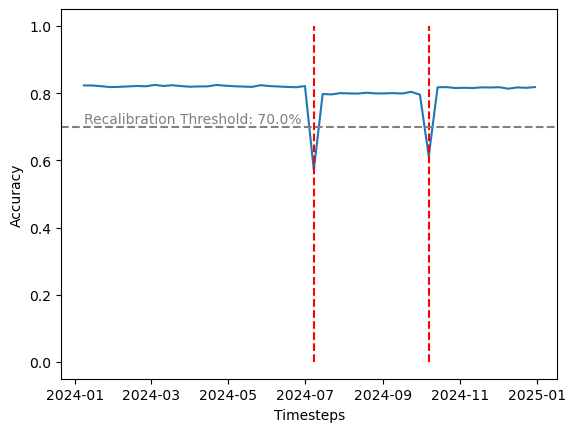

In [59]:
# Plot the accuracy in a linegraph
plt.plot(log['Accuracy'].keys(), log['Accuracy'].values())
# Add dashed line to indicate when the model was recalibrated
plt.vlines(log['Model Updated'].keys(), 0, 1, colors='r', linestyles='dashed')
plt.axhline(y=recalthreshold, color='grey', linestyle='--')
plt.text(min(log['Accuracy'].keys()), recalthreshold+0.01, f'Recalibration Threshold: {recalthreshold*100}%', fontsize=10, color='grey')
plt.xlabel('Timesteps')
plt.ylabel('Accuracy')
plt.show()

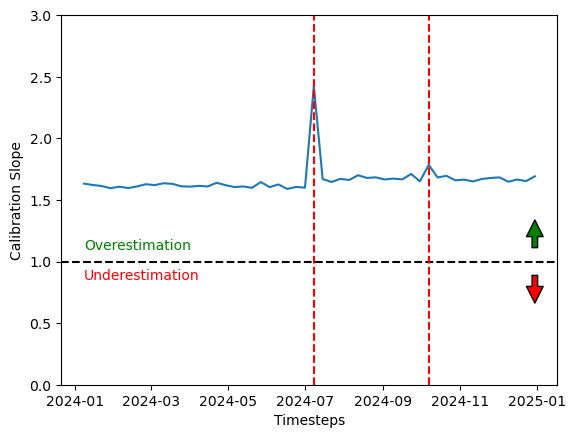

In [60]:
# Plot the calibration slope values in a linegraph
plt.plot(log['CalibrationSlope'].keys(), log['CalibrationSlope'].values())

plt.axhline(y=1, color='black', linestyle='--')
plt.annotate('', xy=(max(log['CoxSnellR2'].keys()), 1.35), xytext=(max(log['CoxSnellR2'].keys()), 1.1),
            arrowprops=dict(facecolor='green', shrink=0.05))
plt.text(min(log['CoxSnellR2'].keys()), 1.1, 'Overestimation', fontsize=10, color='green')
plt.annotate('', xy=(max(log['CoxSnellR2'].keys()), 0.65), xytext=(max(log['CITL'].keys()), 0.9),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.text(min(log['CoxSnellR2'].keys()), 0.85, 'Underestimation', fontsize=10, color='red')

# Add dashed line to indicate when the model was recalibrated
plt.vlines(log['Model Updated'].keys(), 0, 5, colors='r', linestyles='dashed')
plt.ylim(0, 3)
plt.xlabel('Timesteps')
plt.ylabel('Calibration Slope')
plt.show()

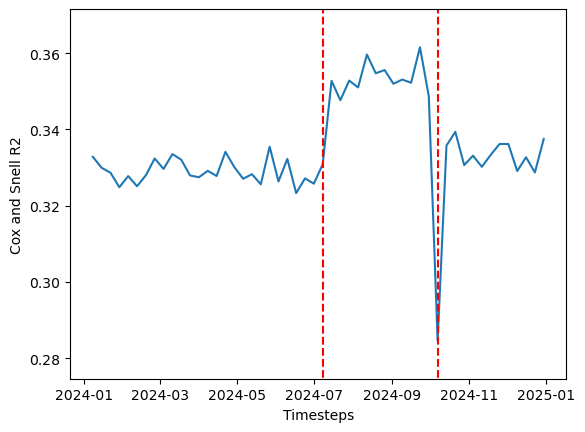

In [61]:
# Plot the calibration slope values in a linegraph
plt.plot(log['CoxSnellR2'].keys(), log['CoxSnellR2'].values())
plt.vlines(log['Model Updated'].keys(), min(log['CoxSnellR2'].values())-0.2, max(log['CoxSnellR2'].values())+0.2, colors='r', linestyles='dashed')
plt.ylim(min(log['CoxSnellR2'].values())-0.01, max(log['CoxSnellR2'].values())+0.01)
plt.xlabel('Timesteps')
plt.ylabel('Cox and Snell R2')
plt.show()

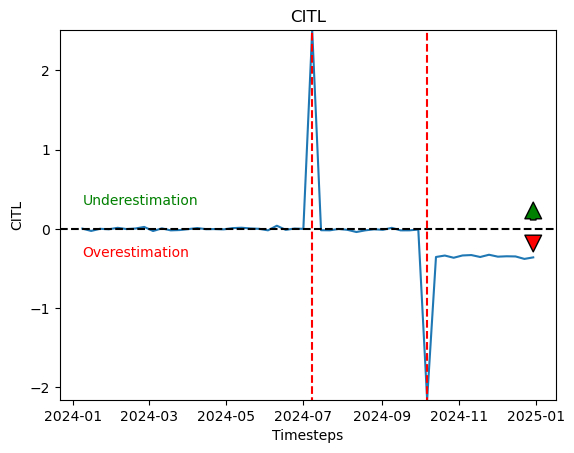

In [62]:
plt.figure()
plt.plot(log['CITL'].keys(), log['CITL'].values())
plt.axhline(y=0, color='black', linestyle='--')
plt.annotate('', xy=(max(log['CITL'].keys()), 0.35), xytext=(max(log['CITL'].keys()), 0.1),
            arrowprops=dict(facecolor='green', shrink=0.05))
plt.text(min(log['CITL'].keys()), 0.3, 'Underestimation', fontsize=10, color='green')
plt.annotate('', xy=(max(log['CITL'].keys()), -0.3), xytext=(max(log['CITL'].keys()), -0.1),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.text(min(log['CITL'].keys()), -0.35, 'Overestimation', fontsize=10, color='red')
plt.vlines(log['Model Updated'].keys(), min(log['CITL'].values())-0.2, max(log['CITL'].values())+0.2, colors='r', linestyles='dashed')
plt.ylim(min(log['CITL'].values()), max(log['CITL'].values()))
plt.title('CITL')
plt.xlabel('Timesteps')
plt.ylabel('CITL')
plt.show()